In [1]:
source('../../functions.R')
eos = readRDS('Data/eosinophil_seurat.RDS')
tcelle = readRDS('Data/tcell_e.RDS')
setwd('Figures/Figure 4')

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

In [2]:
# read in database of ligand/receptor pairs and filter to interactions that are included in gene expression data
pairs = read.csv('receptor_ligand_Ramilowski_modified.csv') %>% filter(Pair.Evidence == 'literature supported', Pair.Source == 'known') %>%
filter(Ligand_ApprovedSymbol %in% rownames(tcelle@data), Receptor_ApprovedSymbol %in% rownames(tcelle@data))


In [3]:
# calculate eosinophil receptor sctores
eo_receptors = eos@data[pairs$Receptor_ApprovedSymbol,eos@meta.data$sub_phenotype == 'Eosinophil' & eos@meta.data$tissue == 'Esophagus']
eo_receptors = apply(eo_receptors, 1, function(x) sum(x > 0)/length(x))
pairs$eo_frac = eo_receptors

eo_receptors = eo_receptors[order(eo_receptors, decreasing = TRUE)]
eo_receptor_scores = eos@data[pairs$Receptor_ApprovedSymbol,]
eo_receptor_scores = apply(eo_receptor_scores, 1 , function(x) mean(x))
pairs$ReceptorScore = eo_receptor_scores

In [4]:
# calculate ligand scores for peTh2 cells and all T cells
cluster = 'E6'
tcell_ligands = tcelle@data[pairs$Ligand_ApprovedSymbol,tcelle@meta.data$plot_cluster == cluster]
tcell_ligands = apply(tcell_ligands, 1, function(x) sum(x > 0)/length(x))
pairs$cluster_frac = tcell_ligands

expressed_ligands = as.numeric(tcell_ligands > .10)
tcell_ligands = tcell_ligands[order(tcell_ligands, decreasing = TRUE)]
tcell_ligand_scores = tcelle@data[pairs$Ligand_ApprovedSymbol,tcelle@meta.data$plot_cluster == cluster]
tcell_ligand_scores = apply(tcell_ligand_scores, 1 , function(x) mean(x))
pairs$cluster_score = tcell_ligand_scores

    
all_t_score = tcelle@data[pairs$Ligand_ApprovedSymbol,tcelle@meta.data$plot_cluster != cluster]
all_t_score = apply(all_t_score, 1 , function(x) mean(x))
pairs$allT_score = all_t_score


In [5]:
# permute T cell labels to assess signifigance
nrep = 10000
set.seed(1)
perm_mat = matrix(0, dim(pairs)[1], nrep) 
data = tcelle@data[pairs$Ligand_ApprovedSymbol,]
for (i in 1:nrep) {
    t_phenos = sample(tcelle@meta.data$plot_cluster)
    data_sub = data[,t_phenos == cluster]
    means = apply(data_sub, 1, mean) 
    perm_mat[,i] = means
    
}

In [6]:
# callculate percentile for each ligand interaction
pairs$percentile_ligand = NA
for (a in 1:dim(pairs)[1]) {
    pairs$percentile_ligand[a] = sum(perm_mat[a,] > pairs$cluster_score[a])
}




 plot_interactions = pairs %>% filter(cluster_frac > .05, eo_frac > .05)  %>% select(Pair.Name, Ligand_ApprovedSymbol, Receptor_ApprovedSymbol, 
                                                                                     cluster_score, ReceptorScore,cluster_frac, eo_frac, percentile_ligand, allT_score) %>% 
               mutate(fc = cluster_score/allT_score) %>% arrange(desc(fc), percentile_ligand, cluster_score) %>% filter()
plot_interactions
dim(plot_interactions)

Pair.Name,Ligand_ApprovedSymbol,Receptor_ApprovedSymbol,cluster_score,ReceptorScore,cluster_frac,eo_frac,percentile_ligand,allT_score,fc
IL5_CSF2RB,IL5,CSF2RB,0.69063549,1.28393009,0.36864407,0.57258065,0,0.0006454987,1069.9254061
IL5_IL5RA,IL5,IL5RA,0.69063549,0.11149450,0.36864407,0.07056452,0,0.0006454987,1069.9254061
GDF7_BMPR2,GDF7,BMPR2,0.24072819,0.10440380,0.16525424,0.07459677,0,0.0014285397,168.5134827
IL13_IL13RA1,IL13,IL13RA1,0.73305186,1.00709269,0.36016949,0.54233871,0,0.0052522811,139.5682835
IL13_IL2RG,IL13,IL2RG,0.73305186,0.48539704,0.36016949,0.26209677,0,0.0052522811,139.5682835
IL13_IL4R,IL13,IL4R,0.73305186,0.99501683,0.36016949,0.48185484,0,0.0052522811,139.5682835
IL4_IL13RA1,IL4,IL13RA1,0.06634616,1.00709269,0.05932203,0.54233871,0,0.0005098179,130.1369644
IL4_IL2RG,IL4,IL2RG,0.06634616,0.48539704,0.05932203,0.26209677,0,0.0005098179,130.1369644
IL4_IL4R,IL4,IL4R,0.06634616,0.99501683,0.05932203,0.48185484,0,0.0005098179,130.1369644
CXCL13_CXCR5,CXCL13,CXCR5,0.28316390,0.14956157,0.09745763,0.11693548,0,0.0045045849,62.8612647


[1] 37 10

In [7]:
seurat =readRDS('../../Data/tissue_seurat.RDS')
seurat = SubsetData(seurat, seurat@cell.names[seurat@meta.data$tissue == 'Esophagus'], subset.raw = TRUE)


In [8]:
nrep = 10000
set.seed(1)
perm_mat = matrix(0, dim(pairs)[1], nrep) 
data = seurat@data[pairs$Receptor_ApprovedSymbol,]
seurat@meta.data$eosinophil = 0
seurat@meta.data[eos@cell.names[eos@meta.data$sub_phenotype == 'Eosinophil' & eos@meta.data$tissue == 'Esophagus'], 'eosinophil'] = 1
for (i in 1:nrep) {
    t_phenos = sample(seurat@meta.data$eosinophil)
    data_sub = data[,t_phenos == 1]
    means = apply(data_sub, 1, mean) 
    perm_mat[,i] = means
}

In [9]:
eoscore = eos@data[pairs$Receptor_ApprovedSymbol, seurat@cell.names[seurat@meta.data$eosinophil == 1]]
eoscore = apply(eoscore, 1, mean)
pairs$eoscore = eoscore
pairs$percentile_receptor = NA
for (a in 1:dim(pairs)[1]) {
    pairs$percentile_receptor[a] = sum(perm_mat[a,] > pairs$eoscore[a])
}




 plot_interactions = pairs %>% filter(cluster_frac > .05, eo_frac > .05)  %>% select(Pair.Name, Ligand_ApprovedSymbol, Receptor_ApprovedSymbol, 
                                                                                     cluster_score, ReceptorScore,cluster_frac, eo_frac, percentile_ligand, allT_score, eoscore, percentile_receptor) %>% 
               mutate(fc = cluster_score/allT_score) %>% arrange(desc(fc), percentile_ligand, cluster_score) %>% filter(percentile_ligand < 500/dim(pairs)[1], percentile_receptor < 500/dim(pairs)[1])
plot_interactions
dim(plot_interactions)

Pair.Name,Ligand_ApprovedSymbol,Receptor_ApprovedSymbol,cluster_score,ReceptorScore,cluster_frac,eo_frac,percentile_ligand,allT_score,eoscore,percentile_receptor,fc
IL5_CSF2RB,IL5,CSF2RB,0.69063549,1.2839301,0.36864407,0.57258065,0,0.0006454987,1.2615523,0,1069.925406
IL5_IL5RA,IL5,IL5RA,0.69063549,0.1114945,0.36864407,0.07056452,0,0.0006454987,0.1070370,0,1069.925406
IL13_IL13RA1,IL13,IL13RA1,0.73305186,1.0070927,0.36016949,0.54233871,0,0.0052522811,1.0879245,0,139.568284
IL13_IL4R,IL13,IL4R,0.73305186,0.9950168,0.36016949,0.48185484,0,0.0052522811,1.0756047,0,139.568284
IL4_IL13RA1,IL4,IL13RA1,0.06634616,1.0070927,0.05932203,0.54233871,0,0.0005098179,1.0879245,0,130.136964
IL4_IL4R,IL4,IL4R,0.06634616,0.9950168,0.05932203,0.48185484,0,0.0005098179,1.0756047,0,130.136964
CXCL13_CXCR5,CXCL13,CXCR5,0.28316390,0.1495616,0.09745763,0.11693548,0,0.0045045849,0.1994586,0,62.861265
PTGS2_PTGDR2,PTGS2,PTGDR2,0.65186013,0.2548338,0.23728814,0.15524194,0,0.0289270364,0.2625793,0,22.534632
ICAM2_ITGB2,ICAM2,ITGB2,0.23721611,2.2823079,0.19915254,0.82862903,0,0.0909233645,2.2295126,0,2.608968


[1]  9 12

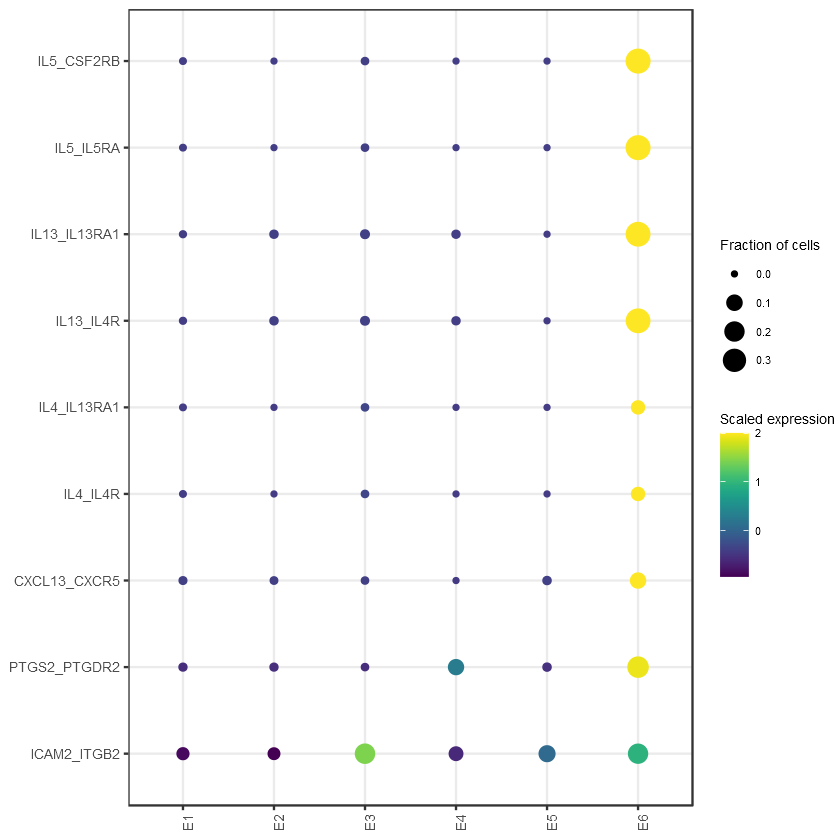

In [10]:
receptors_use = plot_interactions$Ligand_ApprovedSymbol
genes = as.character(plot_interactions$Pair.Name)
data = tcelle@data[as.character(receptors_use),] %>% as.matrix() %>% t()  %>% as.data.frame()
data$phenotype = as.character(tcelle@meta.data$plot_cluster)

colnames(data)= c(genes, 'phenotype')
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp))  %>% as.data.frame()
rownames(df_exp) = df_exp$phenotype
df_exp = df_exp[,-1]
df_exp = scale(df_exp)
df_exp = as.data.frame(df_exp)
df_exp$phenotype = rownames(df_exp)
df_exp = df_exp %>% melt(id.vars = 'phenotype') %>% as.data.frame()
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value = as.numeric(df_exp$value)


df_exp$value[df_exp$value >2] = 2
df_exp$value[df_exp$value < -1]= -1


df_exp$pct = df_pct$value
#df_exp$value = as.vector(df_exp$value)
#df_exp$value[is.nan(df_exp$value)] = 0

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Scaled expression", size = 'Fraction of cells')  + scale_y_discrete(limits = c('E1', 'E2', 'E3',  'E4',  'E5', 'E6')) + 
scale_x_discrete(limits = rev(colnames(data)[-10]), labels = rev(plot_interactions$Pair.Name)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text.x = element_text(size = 8), axis.text.y = element_text(size = 8)) + coord_flip()
ggsave('receptors.pdf', width = 4, height = 3, useDingbats = FALSE)
df_exp_receptor = df_exp

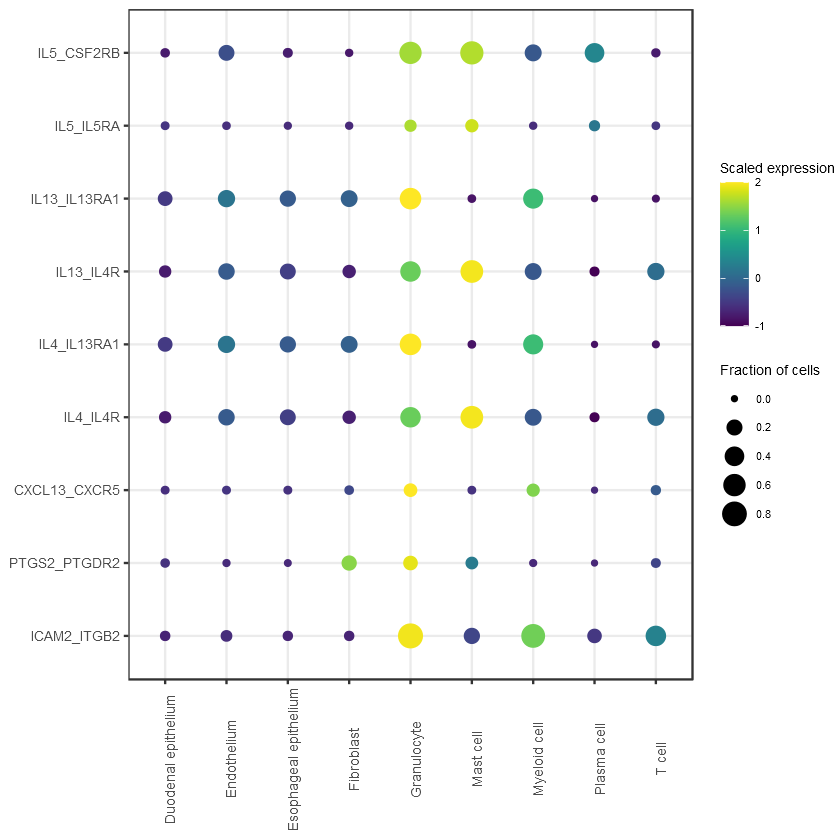

In [11]:
receptors_use = plot_interactions$Receptor_ApprovedSymbol
genes = as.character(plot_interactions$Pair.Name)
data = seurat@data[as.character(receptors_use),] %>% as.matrix() %>% t()  %>% as.data.frame()
data$phenotype = as.character(seurat@meta.data$phenotype)

colnames(data)= c(genes, 'phenotype')
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp))  %>% as.data.frame()
rownames(df_exp) = df_exp$phenotype
df_exp = df_exp[,-1]
df_exp = scale(df_exp)
df_exp = as.data.frame(df_exp)
df_exp$phenotype = rownames(df_exp)
df_exp = df_exp %>% melt(id.vars = 'phenotype') %>% as.data.frame()
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value = as.numeric(df_exp$value)


df_exp$value[df_exp$value >2] = 2
df_exp$value[df_exp$value < -1]= -1


df_exp$pct = df_pct$value
#df_exp$value = as.vector(df_exp$value)
#df_exp$value[is.nan(df_exp$value)] = 0

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Scaled expression", size = 'Fraction of cells')  + #scale_y_discrete(limits = rev(c('E1', 'E2', 'E3',  'E4',  'E5', 'E6'))) + 
scale_x_discrete(limits = rev(colnames(data)[-10]), labels = rev(plot_interactions$Pair.Name)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text.x = element_text(size = 8), axis.text.y = element_text(size = 8)) + coord_flip()
df_exp_ligand = df_exp

Warning message:
"Removed 9 rows containing missing values (geom_point)."

Warning message:
"Removed 9 rows containing missing values (geom_point)."

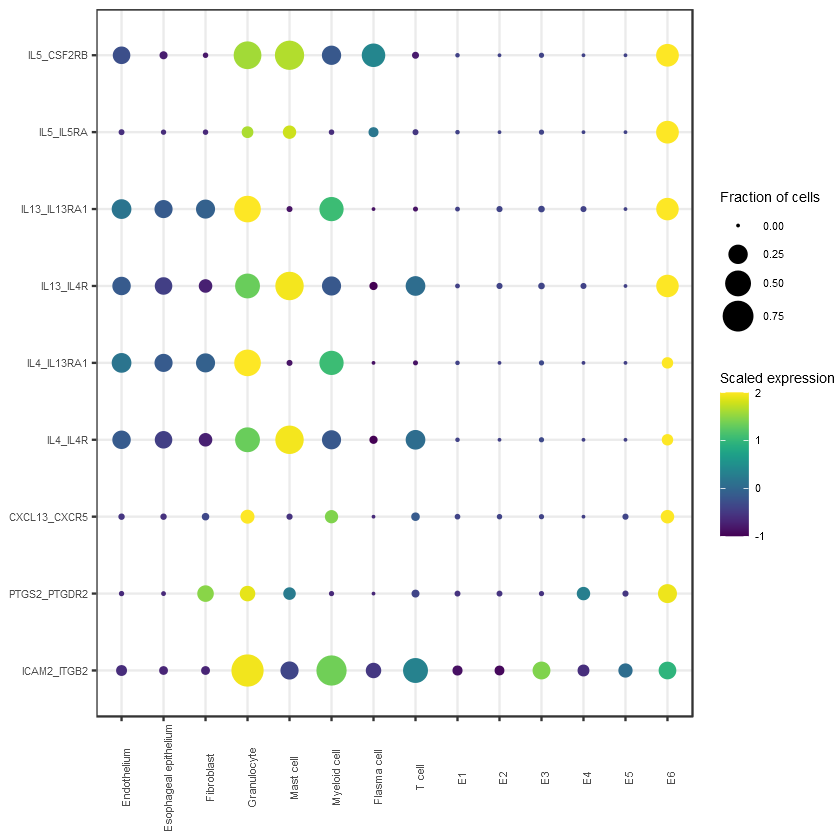

In [12]:
df_both = rbind(df_exp_receptor, df_exp_ligand) %>% filter(phenotype != 'Duodenum epithelium')

ggplot(as.data.frame(df_both), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Scaled expression", size = 'Fraction of cells')  + 
scale_y_discrete(limits = c(unique(df_exp_ligand$phenotype), unique(df_exp_receptor$phenotype))[-1]) + 
scale_x_discrete(limits = rev(colnames(data)[-10]), labels = rev(plot_interactions$Pair.Name)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text.x = element_text(size = 6), axis.text.y = element_text(size = 6)) + coord_flip() + scale_size_continuous(range = c(.01, 8), breaks = c(0,.25, .5, .75))
ggsave('interactions.pdf', height = 3.7, width = 6, useDingbats = FALSE)